In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.signal as signal
from os.path import join as pjoin

In [2]:
def dvb_channel_filter_old(data: np.array, draw=False):
    fpass = 10000000  # Pass band Frequency
    fstop = 15000000  # Stop band Frequency
    apass = 1  # Pass band Ripple (dB)
    astop = 100  # Stop band Attenuation (dB)
    fs = 30000000  # Sampling FrequencyV
    wp = fpass / fs
    ws = fstop / fs
    b, a = signal.iirdesign(wp, ws, apass, astop, ftype="ellip", output="ba")
    filtered_data = signal.lfilter(b, a, data)
    if draw:
        w, h = signal.freqz(b, a, worN=8000)
        plt.plot(w / np.pi, abs(h))
        plt.title("Filter Frequency Response")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Gain")
        plt.grid(True)
        plt.show()
    return filtered_data


def dvb_channel_filter(data: np.array, draw=False):
    fpass = 10000000  # Pass band Frequency
    fstop = 15000000  # Stop band Frequency
    apass = 1  # Pass band Ripple (dB)
    astop = 100  # Stop band Attenuation (dB)
    # astop = 50  # Stop band Attenuation (dB)
    fs = 30000000  # Sampling FrequencyV
    wp = fpass / fs
    ws = fstop / fs
    h = signal.firwin(100, 7e6, fs=fs)
    filtered_data = signal.lfilter(h, 1.0, data)
    if draw:
        w, h = signal.freqz(h, 1.0, worN=8000)
        plt.semilogy(w / np.pi, abs(h))
        plt.title("Filter Frequency Response")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Gain")
        plt.grid(True)
        plt.show()
    return filtered_data

Load data

In [3]:
dvbt_data = sio.loadmat(pjoin("data", "dvbt.mat"))
fc = dvbt_data["fc"][0][0]
f1 = dvbt_data["f1"][0][0]
f2 = dvbt_data["f2"][0][0]
fs = dvbt_data["fs"][0][0]
data = np.squeeze(dvbt_data["data"])

For testing purposes limit number of processed data

In [4]:
data = data[0:200000]
N = len(data)
n = np.linspace(-0.5, 0.5, N)

Plot fft of received data

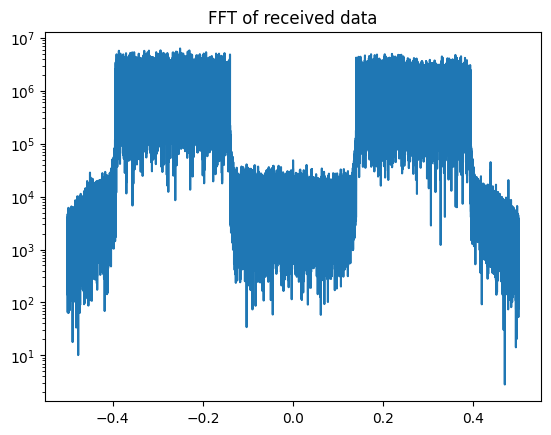

In [5]:
plt.semilogy(n, np.abs(np.fft.fftshift(np.fft.fft(data))))
plt.title("FFT of received data")
plt.show()

Mix frequencies to lower frequency of examined signal

In [6]:
fo = 8e6 / fs
k = np.arange(1, len(data) + 1)
c = np.exp(-1j * (2 * np.pi * fo * k))
data_low = np.multiply(data, c)

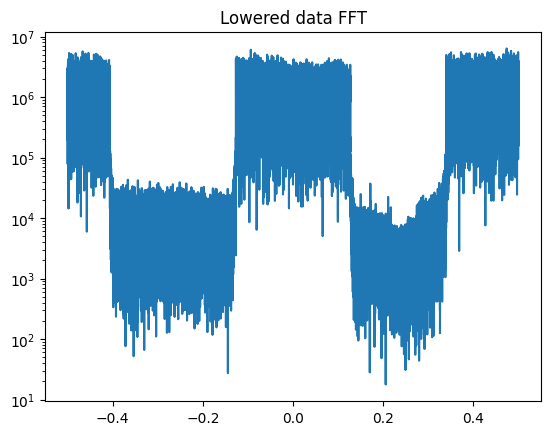

In [7]:
plt.figure()
plt.semilogy(n, np.abs(np.fft.fftshift(np.fft.fft(data_low))))
plt.title("Lowered data FFT")
plt.show()

Filter received data

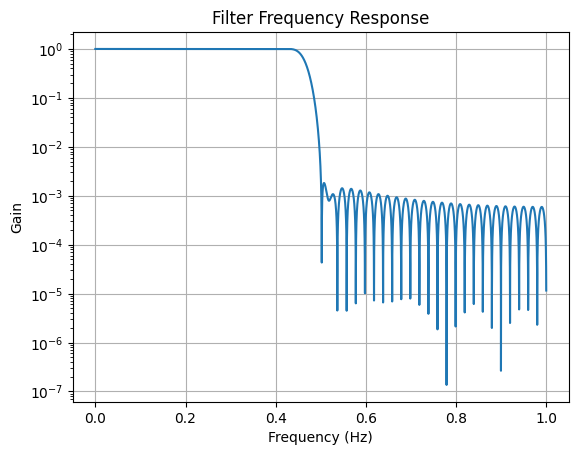

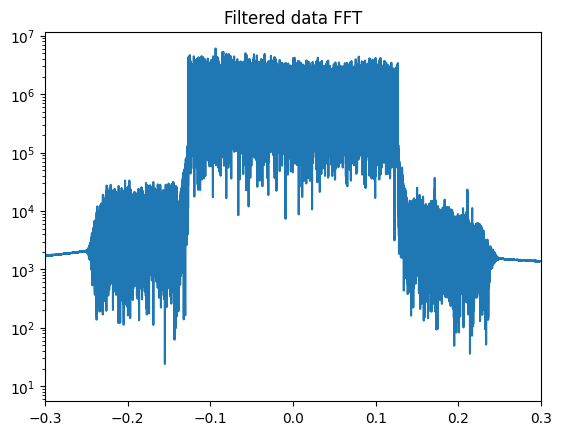

In [8]:
data_filtered = dvb_channel_filter(data_low, draw=True)
plt.figure()
plt.semilogy(n, np.abs(np.fft.fftshift(np.fft.fft(data_filtered))))
plt.title("Filtered data FFT")
plt.xlim([-0.3, 0.3])
plt.show()

Resampling

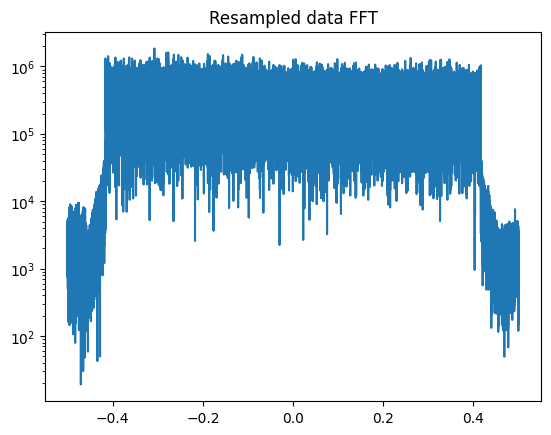

In [9]:
B = 8e6
fs_dvb = 8 / 7 * B
data_resampled = signal.resample(data_filtered, int(N * fs_dvb / fs))
# data_resampled = signal.resample_poly(data_filtered, int(fs_dvb), int(fs))
N_resampled = len(data_resampled)
n_resampled = np.linspace(-0.5, 0.5, N_resampled)
plt.figure()
plt.semilogy(n_resampled, np.abs(np.fft.fftshift(np.fft.fft(data_resampled))))
plt.title("Resampled data FFT")
plt.show()

Find symbols

In [10]:
symbol_per_block = 8192
guard_interval = 1 / 8
guard_symbols = int(symbol_per_block * guard_interval)
# frame_len = int(symbol_per_block + guard_symbols)
correlation = np.zeros(N_resampled, dtype=complex)
for i in range(N_resampled):
    if i + symbol_per_block + guard_symbols > N_resampled:
        break
    first_guard = data_resampled[i : i + guard_symbols]
    second_guard = data_resampled[
        i + symbol_per_block : i + symbol_per_block + guard_symbols
    ]
    corr = np.correlate(first_guard, second_guard)
    correlation[i] = corr[0]

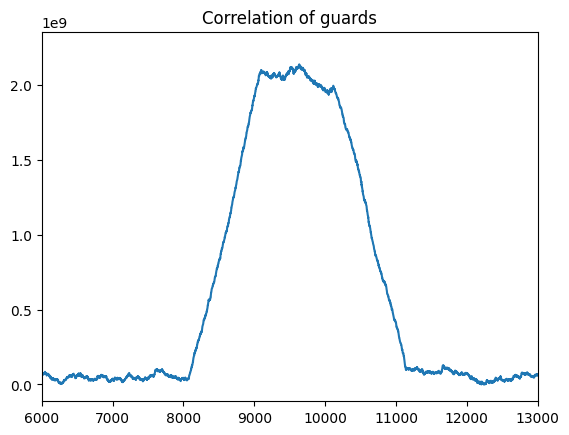

In [16]:
plt.figure()
plt.plot(np.abs(correlation))
plt.title("Correlation of guards")
plt.xlim([6000, 13000])
plt.show()